# Exemplos utilização PVGIS

Demonstração de várias opções para obter dados de produção do PVGIS.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline  
import locale
locale.setlocale(locale.LC_TIME, "pt_PT") # processar datas em PT
import aosol.series.pvgis as pvgis
import aosol.series.producao as seriesprod

Opções base para um sistema:

* Potência de 1kWp
* Localização em Lisboa
* Orientação a sul (azimute = 0)
* Inclinação dos módulos (30º)

Há a opção de obter os dados PVGIS para um ano específico ou então obter os dados para o periodo existente (20 anos ou outro) e fazer a média a cada hora do ano. 

In [2]:
# =====================
# Producao
# =====================
capacidade_instalada = 1 # em kW
ano_producao = 2023 # converter as datas de producao para este ano
# Opcoes API PVGIS
inicio_ano_pvgis = 2021
fim_ano_pvgis = 2021 # PVGIS-SARAH3 na V5.3 (2005-2023)
lat = 38.75  # Covilha
lon = -9.195
inclinacao = 30
azimute = 0.0 # azimute = 180 + x; 0 = Sul
perdas = 14 # %
eficiencia_inversor = 0.96

## 1 kWp para 1 ano

In [3]:
producao = pvgis.get_pvgis_hourly(lat, lon, inicio_ano_pvgis, fim_ano_pvgis, surface_tilt=inclinacao, surface_azimuth=azimute, peakpower=capacidade_instalada, loss=perdas)
producao_sist1_1ano = seriesprod.converter_pvgis_data(producao, ano_producao)

## 1 kWp para 20 anos

In [4]:
inicio_ano_pvgis = 2005
fim_ano_pvgis = 2023
producao = pvgis.get_pvgis_hourly(lat, lon, inicio_ano_pvgis, fim_ano_pvgis, surface_tilt=inclinacao, surface_azimuth=azimute, peakpower=capacidade_instalada, loss=perdas)
producao_sist1 = seriesprod.converter_pvgis_multiyear_ts(producao, ano_producao)

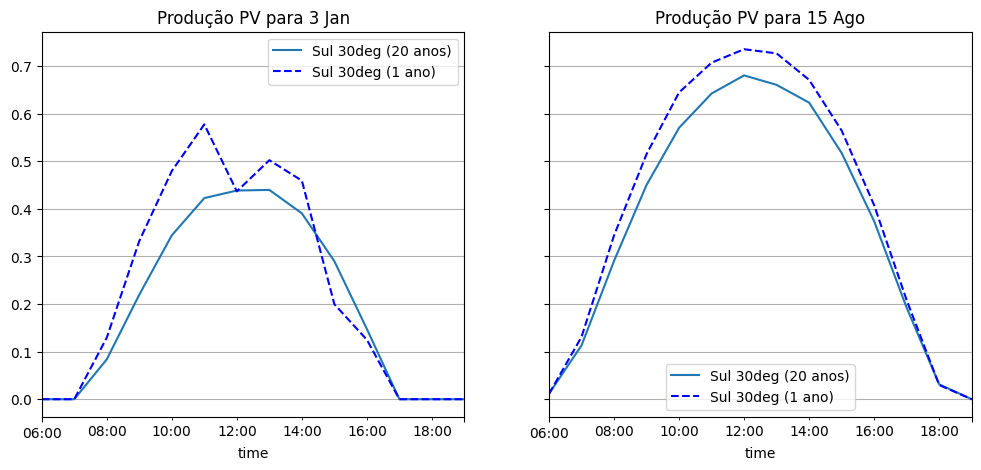

In [5]:
fig, ax = plt.subplots(1,2, figsize=(12,5), sharey=True)

producao_sist1.loc[(producao_sist1.index.dayofyear == 3) & (producao_sist1.index.hour >=6) & (producao_sist1.index.hour <= 19), "autoproducao"].plot(ax=ax[0], label='Sul 30deg (20 anos)')
producao_sist1_1ano.loc[(producao_sist1_1ano.index.dayofyear == 3) & (producao_sist1_1ano.index.hour >=6) & (producao_sist1_1ano.index.hour <= 19), "autoproducao"].plot(ax=ax[0], linestyle='--', color='b', label='Sul 30deg (1 ano)')
ax[0].set_title('Produção PV para 3 Jan')
ax[0].grid()
ax[0].legend()

producao_sist1.loc[(producao_sist1.index.dayofyear == 227) & (producao_sist1.index.hour >=6) & (producao_sist1.index.hour <= 19) , "autoproducao"].plot(ax=ax[1], label='Sul 30deg (20 anos)')
producao_sist1_1ano.loc[(producao_sist1_1ano.index.dayofyear == 227) & (producao_sist1_1ano.index.hour >=6) & (producao_sist1_1ano.index.hour <= 19), "autoproducao"].plot(ax=ax[1], linestyle='--', color='b', label='Sul 30deg (1 ano)')
ax[1].set_title('Produção PV para 15 Ago')
ax[1].grid()
ax[1].legend()

## 0.5 kWp orientado a Este e 0.5 kWp orientado a Oeste

In [6]:
azimute1 = -90 # SSE
azimute2 = 90  # SSW

producao = pvgis.get_pvgis_hourly(lat, lon, inicio_ano_pvgis, fim_ano_pvgis, surface_tilt=inclinacao, surface_azimuth=azimute1, peakpower=capacidade_instalada*0.5, loss=perdas)
producao_sist2_sse = seriesprod.converter_pvgis_multiyear_ts(producao, ano_producao)

producao = pvgis.get_pvgis_hourly(lat, lon, inicio_ano_pvgis, fim_ano_pvgis, surface_tilt=inclinacao, surface_azimuth=azimute2, peakpower=capacidade_instalada*0.5, loss=perdas)
producao_sist2_ssw = seriesprod.converter_pvgis_multiyear_ts(producao, ano_producao)
producao_sist2 = producao_sist2_sse + producao_sist2_ssw

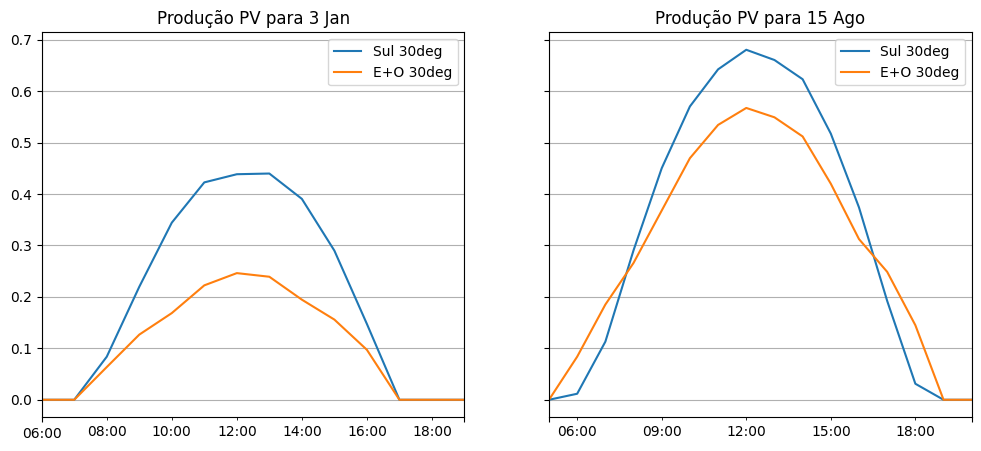

In [7]:
fig, ax = plt.subplots(1,2, figsize=(12,5), sharey=True)

producao_sist1.loc[(producao_sist1.index.dayofyear == 3) & (producao_sist1.index.hour >=6) & (producao_sist1.index.hour <= 19), "autoproducao"].plot(ax=ax[0], label='Sul 30deg')
producao_sist2.loc[(producao_sist2.index.dayofyear == 3) & (producao_sist2.index.hour >=6) & (producao_sist2.index.hour <= 19), "autoproducao"].plot(ax=ax[0], label='E+O 30deg')
ax[0].set_title('Produção PV para 3 Jan')
ax[0].grid()
ax[0].legend()

producao_sist1.loc[(producao_sist1.index.dayofyear == 227) & (producao_sist1.index.hour >=5) & (producao_sist1.index.hour <= 20), "autoproducao"].plot(ax=ax[1], label='Sul 30deg')
producao_sist2.loc[(producao_sist2.index.dayofyear == 227) & (producao_sist2.index.hour >=5) & (producao_sist2.index.hour <= 20), "autoproducao"].plot(ax=ax[1], label='E+O 30deg')
ax[1].set_title('Produção PV para 15 Ago')
ax[1].grid()
ax[1].legend()

## Bifaciais com $\varphi = 80$% orientados a sul

Método recomendado pelo PVGIS só é válido para módulos orientados a sul e _standalone_, não integrados em edificos. [Ver aqui](https://joint-research-centre.ec.europa.eu/photovoltaic-geographical-information-system-pvgis/getting-started-pvgis/pvgis-user-manual_en#ref-4-calculating-grid-connected-pv-system-performance)

Utiliza a potência instalada da parte frontal e o factor de bifacilidade $\varphi$

$P_{BNPI} = P_{STC} * ( 1 + \varphi*0.135)$

In [8]:
capacidade_instalada = 1
factor_bifacialidade = 0.8
pot_bifacial = capacidade_instalada * (1 + factor_bifacialidade*0.135)
print(f"Potencia bifacial = {pot_bifacial:.2f} kWp")

producao = pvgis.get_pvgis_hourly(lat, lon, inicio_ano_pvgis, fim_ano_pvgis, surface_tilt=inclinacao, surface_azimuth=azimute, peakpower=pot_bifacial, loss=perdas)
producao_sist3 = seriesprod.converter_pvgis_multiyear_ts(producao, ano_producao)

Potencia bifacial = 1.11 kWp


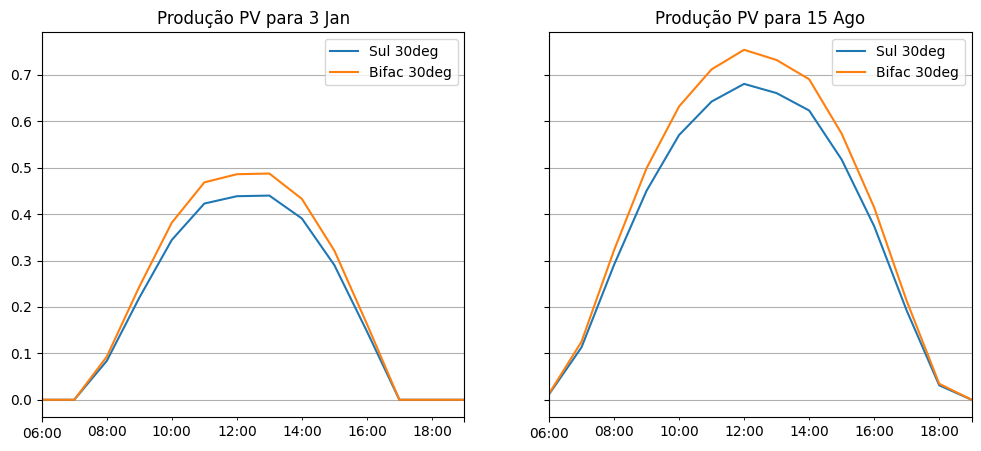

In [9]:
fig, ax = plt.subplots(1,2, figsize=(12,5), sharey=True)

producao_sist1.loc[(producao_sist1.index.dayofyear == 3) & (producao_sist1.index.hour >=6) & (producao_sist1.index.hour <= 19), "autoproducao"].plot(ax=ax[0], label='Sul 30deg')
producao_sist3.loc[(producao_sist3.index.dayofyear == 3) & (producao_sist3.index.hour >=6) & (producao_sist3.index.hour <= 19), "autoproducao"].plot(ax=ax[0], label='Bifac 30deg')
ax[0].set_title('Produção PV para 3 Jan')
ax[0].grid()
ax[0].legend()

producao_sist1.loc[(producao_sist1.index.dayofyear == 227) & (producao_sist1.index.hour >=6) & (producao_sist1.index.hour <= 19) , "autoproducao"].plot(ax=ax[1], label='Sul 30deg')
producao_sist3.loc[(producao_sist3.index.dayofyear == 227) & (producao_sist3.index.hour >=6) & (producao_sist3.index.hour <= 19), "autoproducao"].plot(ax=ax[1], label='Bifac 30deg')
ax[1].set_title('Produção PV para 15 Ago')
ax[1].grid()
ax[1].legend()